# CISC 873 Data Mining Competition #6
name: Asmaa Qindeel


Competition #6: https://www.kaggle.com/competitions/cisc873-dm-f22-a6

# TOPICS:
* [Questions & Answers](#Questions)
* [Problem and Protocol](#intro)

**Code Part**
* [Preparing workspace: gathering info about the data](#pre)

* [Trail 1:](#t1)
* [Trail 2:](#t2)
* [Trail 3:](#t3)
* [Trail 4:](#t4)
* [Trail 5:](#t5)
* [Trial 6:](#t6)
* [Trial 7:](#t7)
* [Trial 8:](#t8)
* [Trial 9:](#t9)
* [Trial 10:](#t10)



[**Conclusion**](#conc)

You have to tune at least 10 times. All the tried solutions should be different (e.g. different feature sets/different preprocessing). The tried solutions should cover at least:

GCN aggregation mechanisms: Tune at least three aggregation mechanisms (aka message_passing mechanisms) used in the graph convolution layer. Explain your understanding (based on the documentation/paper) of the mechanisms you chose.


Up-sampling: adjust the training data preparation/generation part to up-sample the positive class samples (very unbalanced dataset)

<a class="anchor" id="Questions"></a>

# Questions:  

1. Based on the provided template, describe the format of the input file (sdf file).
    - the data is in a Spatial Data File(sdf), means every dataitem is written in a specific place with specific order. Knowing that order is the key to read the file. For instance, in our file the samples are separated by `$$$$`, first line is the id, last line is the label, one column for the nodes, two columns for the edges, one column for edge weights. And a descriptive line, the second line which has the data: (number_of_nodes number_of_edges) in the first two items.
2. What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?
    - three input tensors
        - data(m,): the nodes, which are letters that we tokenize and embed later. dim = m, where m = batch_size * number of nodes in the biggest sample. If batch_size =1, then m = nodes of sample.
        - edge(n,2): the edges of all the samples in the batch. dim = n * 2, where n is the total number of edges in all the batch samples, and 2 because each sample needs 2 items to descripe one edge.
        - node2graph(m): is an indicator of the sample order/index in the batch. m is same m as in data.
        
3. For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?
    - gnn_out(m,32): m as above, with 32 hidden_dim which is the hidden nodes. avg(batch_size,32) takes the mean for each sample, the mean per segment. it reduces the m* 32 dim into batch_size * 32.

4. What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?
    - segment mean may have different size for each segment. reduce_mean splits the input in same sized sets. pred(batch_size, 1), first dim is the batch size or the samples number. second dim is the label dim, since this is binary classification, the output layer has a single node.
5. What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?
    - probably deeper graphs, in here we use 1 GCN layer.

<a class="anchor" id="intro"></a>

# Problem Formulation:
https://www.kaggle.com/c/cisc-873-dm-f22-a3

THis is a classifidation problem, where each input is a graph of a chemical compound. the compound can be classifien as positive or negative for medical purposes.

The input will be in a sdf file format, it needs to be read in order. 

Metric used in this problem is roc_auc.

## The Impact:
Training a model to classify chemical compounds can be used as an attachment to scientific equipment, i.e. make an automatic microscope that can read the sample and identify it with no human error, wouldn't that be nice!

There is a project in AI that is trending now, it is about predicting protien folding, I don't realy understand its impact, but they say it will make a great change in the medical field. such a project also works on graph data input. So including graphs in machine learning is cruicial, not all data is rows and columns. 


# Experimental Protocol:

Read the sdf file, save the data.

For the nodes in graphs We will tokenize and embed them(handle them like text NLP), then the edges will be handled as numeric features.

liberary tf2-gnn is used to include the layers for graph learning.

# References
Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. O’Reilly Media Inc.

[Competition Template](#https://www.kaggle.com/competitions/cisc873-dm-f22-a6/data)

In [8]:
# import libs
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

#the lib for graph convolution
from tf2_gnn.layers.gnn import GNN, GNNInput

import sklearn
import pandas as pd
import numpy as np
import math
import nltk 

In [2]:
#load the data

from tqdm.notebook import tqdm

def read_sdf(file):
    #open the file
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$') # the sign between each two samples
    
    def parse_sample(s):
        #read lines in current sample
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            #read the label line
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            # read the data lines, they start with four spaces
            if l.startswith('    '):
                feature = l.split()
                node = feature[3] 
                nodes.append(node)
            # read the edges lines, they start with one space
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [3]:
from sklearn.model_selection import train_test_split

#split the data to test and validation
training_set = read_sdf('train.sdf')
training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [4]:
# read the test file as well
testing_set  = read_sdf('test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

<a class="anchor" id="pre"></a>

# Preprocesing

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
# tokenize the nodes 

max_vocab = 500
max_len = 100

# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)


def prepare_single_batch(samples):
    '''function to prepare single batch, embed all nodes together, 
    get all edges together, and add node2graph index for each node
    '''
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1] #biggest node number in the samples
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


<a class="anchor" id="t1"></a>

# Trial 1:
use model with one gcn layer and one dense layer, with defalut parameters.
only change the hidden_dim of the gcn layer to 32

- hypers: defalut optimizer(rmsprop)
- batch_size = 16
- epoch = 5

In [6]:


data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

pred = Dense(1, activation='sigmoid')(avg)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 20)           10000       ['input_1[0][0]']            

In [7]:
#compile loss function
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [11]:
#train teh model
batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5


C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C

1330/1330 [==============================] - 28s 18ms/step - loss: 0.2276 - auc: 0.4728 - val_loss: 0.2146 - val_auc: 0.5856
Epoch 2/5
1330/1330 [==============================] - 23s 18ms/step - loss: 0.2006 - auc: 0.5667 - val_loss: 0.2111 - val_auc: 0.6138
Epoch 3/5
1330/1330 [==============================] - 22s 17ms/step - loss: 0.1949 - auc: 0.6133 - val_loss: 0.2064 - val_auc: 0.6683
Epoch 4/5
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1882 - auc: 0.6458 - val_loss: 0.2011 - val_auc: 0.6729
Epoch 5/5
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1826 - auc: 0.6849 - val_loss: 0.1974 - val_auc: 0.7017


In [13]:
#predic and save to file
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred

array([0.09073231, 0.05983728, 0.05978483, ..., 0.019364  , 0.09987938,
       0.02540815], dtype=float32)

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T1.csv')

<a class="anchor" id="t2"></a>
# Trial 2: 


T1 got 0.7 val_accuracy, which is a good start, next i'll try changing one parameter of the model. it is the message passing style, meaning how the model will handle each node in graph, the defalut is `rgcn`, lets change it to `ggnn`.

**setting:**

- one gcn layer with hidden_dim=32
- one dense layer
- hypers: defalut optimizer(rmsprop)
- batch_size = 16
- epoch = 10 + add early stopping

In [13]:
#default message_calculation_class 
params['message_calculation_class']

'rgcn'

In [15]:
#
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['message_calculation_class'] = 'ggnn'
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

 
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
 

pred = Dense(1, activation='sigmoid')(avg)

model2 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 20)           10000       ['input_7[0][0]']          

In [18]:
# train the model
model2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [19]:

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
    callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode = 'min',
    patience=3)]
)

Epoch 1/10


C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense T

1330/1330 [==============================] - 42s 27ms/step - loss: 0.1902 - auc: 0.6182 - val_loss: 0.2053 - val_auc: 0.6378
Epoch 2/10
1330/1330 [==============================] - 35s 26ms/step - loss: 0.1832 - auc: 0.6569 - val_loss: 0.2259 - val_auc: 0.6379
Epoch 3/10
1330/1330 [==============================] - 36s 27ms/step - loss: 0.1828 - auc: 0.6565 - val_loss: 0.1990 - val_auc: 0.6763
Epoch 4/10
1330/1330 [==============================] - 38s 29ms/step - loss: 0.1777 - auc: 0.6947 - val_loss: 0.1886 - val_auc: 0.7265
Epoch 5/10
1330/1330 [==============================] - 36s 27ms/step - loss: 0.1756 - auc: 0.6979 - val_loss: 0.1966 - val_auc: 0.7129
Epoch 6/10
1330/1330 [==============================] - 36s 27ms/step - loss: 0.1723 - auc: 0.7193 - val_loss: 0.1881 - val_auc: 0.7309
Epoch 7/10
1330/1330 [==============================] - 36s 27ms/step - loss: 0.1707 - auc: 0.7277 - val_loss: 0.1943 - val_auc: 0.7417
Epoch 8/10
1330/1330 [==============================] - 36s

In [25]:
# predict and save to file
y_pred = model2.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T2.csv')

<a class="anchor" id="t3"></a>

# Trial 3:

from trial 1 and 2, `ggnn` is better, also the 5 epochs were not enough. but we are still exploring which method is better, here lets try the `rgin`, which requires a num_aggr_MLP_hidden_layers 

**new setting:**
- one gcn layer with hidden_dim=32
- one dense layer
- hypers: defalut optimizer(rmsprop)
- batch_size = 16
- epoch = 10 + add early stopping

In [20]:
#
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()

params['message_calculation_class'] = 'rgin'

# change the num_aggr_MLP_hidden_layers
params['num_aggr_MLP_hidden_layers'] = 16
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

pred = Dense(1, activation='sigmoid')(avg)


model3 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 20)           10000       ['input_10[0][0]']         

In [32]:
model3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [33]:
import math

batch_size = 16
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
        callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode = 'min',
    patience=3)]
)

Epoch 1/10


C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgin/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor 

1330/1330 [==============================] - 73s 47ms/step - loss: 0.2299 - auc: 0.5480 - val_loss: 0.2041 - val_auc: 0.6796
Epoch 2/10
1330/1330 [==============================] - 84s 64ms/step - loss: 0.2144 - auc: 0.5689 - val_loss: 0.1917 - val_auc: 0.6411
Epoch 3/10
1330/1330 [==============================] - 76s 57ms/step - loss: 0.2046 - auc: 0.5960 - val_loss: 0.2114 - val_auc: 0.6437
Epoch 4/10
1330/1330 [==============================] - 63s 47ms/step - loss: 0.2156 - auc: 0.5186 - val_loss: 0.2247 - val_auc: 0.3724
Epoch 5/10
1330/1330 [==============================] - 74s 55ms/step - loss: 0.2079 - auc: 0.5179 - val_loss: 0.2092 - val_auc: 0.6564


In [36]:
# predict and save to file 
y_pred = model3.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T3.csv')

<a class="anchor" id="t4"></a>

# Trial 4: Sampling:

As mentioned in the https://www.kaggle.com/competitions/cisc873-dm-f22-a6/overview , the data is unbalanced, so here i try to balance it with simply repeating the minor class nodes.

**new setting:**
- sampling strategy is 1:2 , so that i don't overflood the data with repeated dummy samples.
- one gcn layer with hidden_dim=32
- defalus message_calculation_class = 'rgcn'
- one dense layer
- hypers: defalut optimizer(rmsprop)
- batch_size = 16
- epoch = 10 + add early stopping

In [23]:
import imblearn.over_sampling as over_sampling 
import imblearn.under_sampling as under_sampling
import imblearn.combine as combine
import imblearn.pipeline as imb_pipe
from collections import Counter

In [32]:
#check balance
# turn data to data frame to easily duplicate the minority class later
df = pd.DataFrame(training_set)
X = df.iloc[:, : -1].values
y = df.iloc[:, -1].values
 
# use counter to count the classes # i could use pandas.
c = Counter(y)
c

Counter({0: 20254, 1: 1016})

data ratio of 5:100 , this is enough to render the model biased for the major class

In [33]:
# create 9*duplicates , plus original will be 10
class_oversample = df.loc[df[df[2]==1].index.repeat(9)]

df_over = pd.concat([df, class_oversample])

#check classes now
df_over[2].value_counts()

0    20254
1    10160
Name: 2, dtype: int64

In [34]:
# put it back in the list
training_set_over = df.values.tolist()


In [28]:
#
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

pred = Dense(1, activation='sigmoid')(avg)

model4 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_4 (Embedding)        (None, 20)           10000       ['input_13[0][0]']         

In [126]:
model4.compile(
    #optimizer is rmsprop by defalut
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [127]:
batch_size = 16
num_batchs = math.ceil(len(training_set_over) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model4.fit(
    gen_batch(
        training_set_over, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
     callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode = 'min',
    patience=3)]
)

Epoch 1/10
1905/1905 [==============================] - 38s 18ms/step - loss: 0.5835 - auc: 0.6929 - val_loss: 0.4033 - val_auc: 0.7665
Epoch 2/10
1905/1905 [==============================] - 32s 17ms/step - loss: 0.5416 - auc: 0.7547 - val_loss: 0.3566 - val_auc: 0.7563
Epoch 3/10
1905/1905 [==============================] - 32s 17ms/step - loss: 0.5249 - auc: 0.7771 - val_loss: 0.3587 - val_auc: 0.7668
Epoch 4/10
1905/1905 [==============================] - 34s 18ms/step - loss: 0.5142 - auc: 0.7898 - val_loss: 0.3541 - val_auc: 0.7712
Epoch 5/10
1905/1905 [==============================] - 38s 20ms/step - loss: 0.5079 - auc: 0.7973 - val_loss: 0.3349 - val_auc: 0.7733
Epoch 6/10
1905/1905 [==============================] - 35s 18ms/step - loss: 0.5000 - auc: 0.8045 - val_loss: 0.3998 - val_auc: 0.7915
Epoch 7/10
1905/1905 [==============================] - 35s 18ms/step - loss: 0.4951 - auc: 0.8091 - val_loss: 0.3753 - val_auc: 0.8023
Epoch 8/10
1905/1905 [==========================

In [129]:
y_pred = model4.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
print(y_pred.shape)
y_pred = np.reshape(y_pred, -1)
print(y_pred.shape)
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T4.csv')


<a class="anchor" id="t5"></a>

# Trial 5:
val_acc = 0.79, Seems like oversamplig to ratio 1:2 made a big change.

I'll try another sampling method, the SMOTE. According to this https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
it repeates certain points.


**trial failed** i couldn't get the SMOTE model to take the graph data.

I also tried to create a generator like the gen_batch for the SMOTE model, but that faile too. Tried to build my own smart resampler, also failed. T5 failed.

In [45]:
# full_pipline = imb_pipe(
#     steps=[       
#         ('resampler' , over_sampling.BorderlineSMOTE(sampling_strategy=0.5)), #over sampler
#         ('my_classifier', model4())]
# )

In [73]:
# training_set = pd.DataFrame(training_set)
# oversampler = over_sampling.SMOTE(sampling_strategy=0.5)
# X = oversampler.fit_resample(training_set)
# training_set
# Counter(training_set[0])

In [151]:
# def resampler(samples):
#     sample_nodes = [s[0] for s in samples]
#     sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
#     sample_nodes = pad_sequences(sample_nodes, padding='post')
#     max_nodes_len = np.shape(sample_nodes)[1]
#     edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
#     edges = [e for e in edges if len(e) > 0]
# #     node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
#     all_nodes = np.reshape(sample_nodes, -1)
#     all_edges = np.concatenate(edges)

# #     node_to_graph = np.reshape(node_to_graph, -1)
#     return {
#         'data': all_nodes,
#         'edges': all_edges,
# #         'node2grah': node_to_graph,
#     }, np.array([s[2] for s in samples])

In [140]:
# # resampler
# def iresampler(dataset, batch_size=1, repeat=False, shuffle=False):
#     while True:
#         dataset = list(dataset)
#         if shuffle:
#             random.shuffle(dataset)
#         l = len(dataset)
#         x_dict = {}
#         y_array = np.array(())
#         for ndx in range(0, l, batch_size):
#             batch_samples = dataset[ndx:min(ndx + batch_size, l)]
#             x, y = resampler(batch_samples)
#             np.concatenate((x_dict, x))
            
#         if not repeat:
#             break


In [141]:
# sampler = over_sampling.SMOTE(sampling_strategy=0.5)
# # X, y = sampler.fit_resample(prepare_single_batch(training_set))
# X = resampler(training_set, batch_size=1)


<a class="anchor" id="t6"></a>

# Trial 6:

Same setting as T4, but change the optimizer, the default rmsprop is not converging fast enough

**setting:**
- sampling strategy is 1:2 , so that i don't overflood the data with repeated dummy samples.
- one gcn layer with hidden_dim=32
- defalut message_calculation_class = 'rgcn'
- one dense layer
- hypers: defalut optimizer(rmsprop)
- batch_size = 16
- epoch = 15 + add early stopping

**change**
optimizer : adam

In [29]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

 
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

pred = Dense(1, activation='sigmoid')(avg)

model6 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model6.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_5 (Embedding)        (None, 20)           10000       ['input_16[0][0]']         

In [30]:
model6.compile( optimizer='adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [35]:
batch_size = 16
num_batchs = math.ceil(len(training_set_over) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model6.fit(
    gen_batch(
        training_set_over, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
     callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", mode = 'min',
    patience=5)]
)

Epoch 1/15
1330/1330 [==============================] - 26s 19ms/step - loss: 0.1767 - auc: 0.7087 - val_loss: 0.1941 - val_auc: 0.7190
Epoch 2/15
1330/1330 [==============================] - 25s 18ms/step - loss: 0.1757 - auc: 0.7083 - val_loss: 0.1913 - val_auc: 0.7283
Epoch 3/15
1330/1330 [==============================] - 23s 18ms/step - loss: 0.1723 - auc: 0.7316 - val_loss: 0.1883 - val_auc: 0.7211
Epoch 4/15
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1706 - auc: 0.7418 - val_loss: 0.1913 - val_auc: 0.7740
Epoch 5/15
1330/1330 [==============================] - 23s 18ms/step - loss: 0.1700 - auc: 0.7447 - val_loss: 0.1890 - val_auc: 0.7141
Epoch 6/15
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1685 - auc: 0.7531 - val_loss: 0.1813 - val_auc: 0.7696
Epoch 7/15
1330/1330 [==============================] - 23s 17ms/step - loss: 0.1670 - auc: 0.7628 - val_loss: 0.2033 - val_auc: 0.7359
Epoch 8/15
1330/1330 [==========================

In [165]:
#predict and save to file
y_pred = model6.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)

submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T6.csv')


<a class="anchor" id="t7"></a>

# Trial 7:
build a model with parameters of T4 & T6, which got the highest results in val_acc and in test accuracy over kaggle, so 
oversample and train for more than 10 epochs, and change the message_calculation_class = `ggnn`

**setting**
- sampling strategy is 1:2 , so that i don't overflood the data with repeated dummy samples.
- one gcn layer with hidden_dim=32
- defalut message_calculation_class = 'rgat'
- one dense layer
- hypers: adam
- batch_size = 16
> epoch = 20 , no early stopping

In [54]:
# turn data to data frame to easily duplicate the minority class later
df = pd.DataFrame(training_set)
X = df.iloc[:, : -1].values
y = df.iloc[:, -1].values
 # create 9*duplicates , plus original will be 10
class_oversample = df.loc[df[df[2]==1].index.repeat(9)]

df_over = pd.concat([df, class_oversample])
training_set_over = df.values.tolist()

In [60]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params['message_calculation_class'] = 'rgat'
params['num_heads'] = 16
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

# print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
# print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
# print('pred:', pred)

model7 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model7.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_11 (TFOpLam  ()                  0           ['input_36[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_11 (Embedding)       (None, 20)           10000       ['input_34[0][0]']        

In [61]:
model7.compile( optimizer = 'adam',
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [62]:
%%time


batch_size = 16
num_batchs = math.ceil(len(training_set_over) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model7.fit(
    gen_batch(
        training_set_over, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation, 
    verbose = 1
)

Epoch 1/20


C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/concat_3:0", shape=(None,), dtype=int32), values=Tensor("gradients/concat_2:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgat_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\asmaa\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgat/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgat/embedding_lookup_grad/Reshape:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradients/rgat/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memor

1330/1330 [==============================] - 71s 43ms/step - loss: 0.2301 - auc: 0.4920 - val_loss: 0.2274 - val_auc: 0.6327
Epoch 2/20
1330/1330 [==============================] - 55s 41ms/step - loss: 0.1869 - auc: 0.6367 - val_loss: 0.1992 - val_auc: 0.6661
Epoch 3/20
1330/1330 [==============================] - 58s 43ms/step - loss: 0.1827 - auc: 0.6655 - val_loss: 0.2004 - val_auc: 0.6913
Epoch 4/20
1330/1330 [==============================] - 55s 41ms/step - loss: 0.1799 - auc: 0.6819 - val_loss: 0.2044 - val_auc: 0.6817
Epoch 5/20
1330/1330 [==============================] - 58s 43ms/step - loss: 0.1766 - auc: 0.7106 - val_loss: 0.1947 - val_auc: 0.7173
Epoch 6/20
1330/1330 [==============================] - 55s 41ms/step - loss: 0.1745 - auc: 0.7259 - val_loss: 0.1914 - val_auc: 0.7213
Epoch 7/20
1330/1330 [==============================] - 57s 43ms/step - loss: 0.1743 - auc: 0.7238 - val_loss: 0.1938 - val_auc: 0.7270
Epoch 8/20
1330/1330 [==============================] - 55s

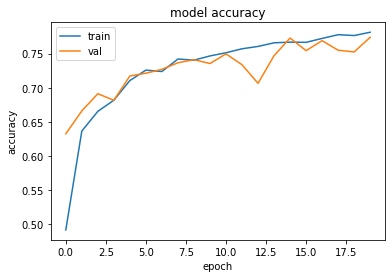

In [63]:
# lets check the overfitting of the model
from matplotlib import pyplot as plt

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

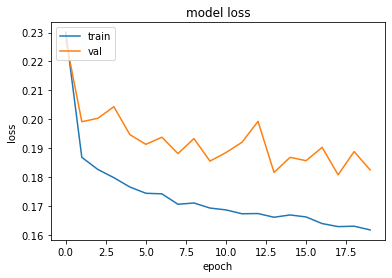

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [188]:
y_pred = model7.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)


submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T7.csv')


<a class="anchor" id="t8"></a>

# Trial 8:
well, we have seen what overfitting looks like :D, it looks like T7. 

**settings** same as T7 but

- make batch_size 32

In [ ]:
# turn data to data frame to easily duplicate the minority class later
df = pd.DataFrame(training_set)
X = df.iloc[:, : -1].values
y = df.iloc[:, -1].values
 # create 9*duplicates , plus original will be 10
class_oversample = df.loc[df[df[2]==1].index.repeat(9)]

df_over = pd.concat([df, class_oversample])
training_set_over = df.values.tolist()

In [66]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

pred = Dense(1, activation='sigmoid')(avg)

model8 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_37 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_12 (TFOpLam  ()                  0           ['input_39[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_12 (Embedding)       (None, 20)           10000       ['input_37[0][0]']        

In [67]:
model8.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [69]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_set_over) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model8.fit(
    gen_batch(
        training_set_over, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5
665/665 [==============================] - 26s 39ms/step - loss: 0.2366 - auc: 0.4760 - val_loss: 0.2218 - val_auc: 0.6523
Epoch 2/5
665/665 [==============================] - 24s 35ms/step - loss: 0.1951 - auc: 0.6014 - val_loss: 0.1991 - val_auc: 0.6339
Epoch 3/5
665/665 [==============================] - 25s 38ms/step - loss: 0.1917 - auc: 0.6189 - val_loss: 0.2150 - val_auc: 0.6756
Epoch 4/5
665/665 [==============================] - 24s 36ms/step - loss: 0.1902 - auc: 0.6276 - val_loss: 0.2013 - val_auc: 0.6593
Epoch 5/5
665/665 [==============================] - 26s 40ms/step - loss: 0.1880 - auc: 0.6472 - val_loss: 0.2018 - val_auc: 0.6750


In [70]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)

y_pred = np.reshape(y_pred, -1)
y_pred

array([0.49969295, 0.49970955, 0.49963474, ..., 0.49972904, 0.4994854 ,
       0.49964124], dtype=float32)

In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('T8.csv')


<a class="anchor" id="t9"></a>

# Trial 9:

I want to try adding more than one gcn layer,

**Status** Trial not completed


In [73]:
# import tensorflow as tf
# from tensorflow.math import segment_mean
# from tensorflow import keras
# from tensorflow.keras import Input, Model
# from tensorflow.keras.layers import Embedding, Dense
# from tensorflow.keras.optimizers import Adam

# from tf2_gnn.layers.gnn import GNN, GNNInput

# data = keras.Input(batch_shape=(None,))

# # the first dim is different to the previous one. it is the total number of edges in this batch
# edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
# node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
# embeded = Embedding(tokenizer.num_words, 20)(data)

# # number of graphs (number of samples)
# num_graph = tf.reduce_max(node2graph)+1

# gnn_input = GNNInput(
#     node_features=embeded,
#     adjacency_lists=(edge,),
#     node_to_graph_map=node2graph, 
#     num_graphs=num_graph,
# )

# # https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# params = GNN.get_default_hyperparameters()
# params["hidden_dim"] = 32
# gnn_layer = GNN(params)
# gnn_1 = GNN(params)
# gnn_1 = gnn_layer(gnn_input)
# gnn_out = gnn_1(params)
# avg = segment_mean(
#     data=gnn_out,
#     segment_ids=node2graph
# )
# print('mean:', avg)

# pred = Dense(1, activation='sigmoid')(avg)
# print('pred:', pred)

# model = Model(
#     inputs={
#         'data': data,
#         'edges': edge,
#         'node2grah': node2graph,
#     },
#     outputs=pred
# )
# model.summary()

<a class="anchor" id="t10"></a>

# Trial 10:
I have no more trial i'd like to proceed.

# Conclusion:
<a class="anchor" id="conc"></a>

Graph data is a big part of real problems, there is a lot of decisions to maake when it comes to training its model, how would the model handle the nodes, individually(attention mode) or dense agggregation to focus on all nodes together, or any other method.
Another consideration is how big should the model be, number of gcn layers 